## Monte Carlo method


The code in the canvas above has been revised to use the Metropolis Monte Carlo method to generate realistic spin configurations at different temperatures, instead of assigning spins randomly.

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [27]:
"""
Example code for classifying 2D Ising model phases with a CNN, using a real
Monte Carlo (Metropolis) simulation for data generation rather than random spins.

Detailed inline comments have been added to clarify the logic of each step.
"""

##############################
# Metropolis MCMC Utilities  #
##############################

def metropolis_single_flip(config, beta, J=1.0):
    """
    Perform one Metropolis sweep over the entire lattice by attempting to flip spins.

    :param config: 2D NumPy array representing spins (+1 or -1) on each site.
    :param beta: Inverse temperature (1 / T). We assume k_B=1 for simplicity.
    :param J: Coupling constant (set to 1.0 for convenience).
    """
    # The lattice is assumed to be a square of shape (lattice_size, lattice_size).
    lattice_size = config.shape[0]

    # We do a total of (lattice_size * lattice_size) attempts, i.e. one attempt per site on average.
    for _ in range(lattice_size * lattice_size):
        # Randomly pick a site (i, j) in the lattice.
        i = np.random.randint(0, lattice_size)
        j = np.random.randint(0, lattice_size)

        # The current spin value at (i, j).
        s = config[i, j]

        # Compute the sum of the four neighboring spins (with periodic boundary conditions).
        # Indices wrap around using modulo, so we effectively have a torus.
        nn_sum = (
            config[(i - 1) % lattice_size, j] +
            config[(i + 1) % lattice_size, j] +
            config[i, (j - 1) % lattice_size] +
            config[i, (j + 1) % lattice_size]
        )

        # Energy change dE if we flip this spin: dE = 2 * J * s * (sum of neighbors)
        # This is because flipping s -> -s changes the local energy by that amount.
        dE = 2.0 * J * s * nn_sum

        # Metropolis acceptance criterion:
        if dE <= 0.0:
            # If flipping lowers energy (dE < 0), accept the flip.
            config[i, j] = -s
        else:
            # Otherwise, flip with probability exp(-beta * dE).
            if np.random.rand() < np.exp(-beta * dE):
                config[i, j] = -s

In [28]:
def metropolis_ising(lattice_size, T, n_sweeps=1000, J=1.0):
    """
    Initialize a random spin configuration and thermalize it using the Metropolis algorithm.

    :param lattice_size: N for an NxN grid.
    :param T: Temperature.
    :param n_sweeps: Number of Metropolis sweeps to perform over the entire lattice.
    :param J: Coupling constant (assumed to be 1 for simplicity).
    :return: A thermalized 2D spin configuration as a NumPy array of shape (lattice_size, lattice_size).
    """
    # beta = 1 / (k_B * T), with k_B = 1.
    beta = 1.0 / T

    # Start with a random configuration of spins (+1 or -1) on the lattice.
    config = np.random.choice([-1, 1], size=(lattice_size, lattice_size))

    # Perform n_sweeps sweeps; each sweep tries flipping spins randomly across the lattice.
    for _ in range(n_sweeps):
        metropolis_single_flip(config, beta, J)

    return config

In [29]:
################################
# Dataset Class with MCMC Data  #
################################

class Ising2DData(Dataset):
    """
    PyTorch Dataset for storing 2D Ising spin configurations generated via Metropolis MCMC.
    Each configuration is labeled 0 (ordered) if T < Tc, else 1 (disordered) if T > Tc.
    """
    def __init__(
        self,
        lattice_size=16,
        num_samples=1000,
        temperatures=[1.0, 3.5],
        Tc=2.269,
        seed=42,
        n_sweeps=1000,
    ):
        """
        :param lattice_size: Size of the NxN lattice.
        :param num_samples: Number of samples to generate for each temperature.
        :param temperatures: List of temperatures to simulate.
        :param Tc: The critical temperature for the 2D Ising model.
        :param seed: Random seed for reproducibility.
        :param n_sweeps: Number of MCMC sweeps per generated configuration.
        """
        super().__init__()
        # Fix the random seed for reproducibility.
        np.random.seed(seed)
        self.lattice_size = lattice_size
        self.num_samples = num_samples
        self.temperatures = temperatures
        self.Tc = Tc
        self.n_sweeps = n_sweeps
        self.configs = []  # Will hold all spin configurations.
        self.labels = []   # Will hold corresponding labels.
        self.generate_data()

    def generate_data(self):
        """
        Generate data for each temperature via the Metropolis MCMC simulation.
        Label each configuration based on whether T < Tc or T > Tc.
        """
        for T in self.temperatures:
            # Determine class label based on T vs. Tc.
            label = 0 if T < self.Tc else 1

            # Generate num_samples spin configurations at this temperature.
            for _ in range(self.num_samples):
                config = metropolis_ising(
                    lattice_size=self.lattice_size,
                    T=T,
                    n_sweeps=self.n_sweeps,
                    J=1.0,
                )
                self.configs.append(config)
                self.labels.append(label)

        # Convert Python lists to NumPy arrays for easier handling.
        self.configs = np.array(self.configs, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)

    def __len__(self):
        # Return the total number of configurations.
        return len(self.configs)

    def __getitem__(self, idx):
        # When the DataLoader requests an item, return (spin_config, label).
        return self.configs[idx], self.labels[idx]


In [30]:
##############################
# The Simple CNN definition #
##############################

class SimpleCNN(nn.Module):
    """
    A small CNN to perform binary classification (ordered vs. disordered) on 2D Ising spin configs.
    """
    def __init__(self, lattice_size=16):
        super(SimpleCNN, self).__init__()
        # First conv layer: input channel = 1 (the spin lattice), output channels = 8.
        # kernel_size=3 with padding=1 preserves the input size.
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        # Second conv layer: input channel = 8, output channels = 16.
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)

        # Pooling layer (2x2). Each pooling halves the spatial dimension.
        self.pool = nn.MaxPool2d(2, 2)

        # After two poolings, dimension is reduced by a factor of 4 (2 in each pooling).
        # For a 16x16 lattice: 16 -> 8 -> 4 in each dimension.
        # So the final feature map has shape: (batch_size, 16, 4, 4) => flattened size = 16 * 4 * 4 = 256.
        flatten_size = 16 * (lattice_size // 4) * (lattice_size // 4)

        # Fully connected layers.
        self.fc1 = nn.Linear(flatten_size, 32)  # Dense layer from 256 to 32.
        self.fc2 = nn.Linear(32, 2)            # Output layer for two classes.

    def forward(self, x):
        # Pass input through first conv -> ReLU -> pool.
        x = self.pool(F.relu(self.conv1(x)))
        # Then second conv -> ReLU -> pool.
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output of conv layers.
        x = x.view(x.size(0), -1)
        # Fully connected + ReLU.
        x = F.relu(self.fc1(x))
        # Final linear layer to get logits for 2 classes.
        x = self.fc2(x)
        return x

In [31]:
##############################
# Training/Validation Logic #
##############################

def train_model(model, dataloader, criterion, optimizer, device):
    # Switch model to training mode.
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over batches from the DataLoader.
    for configs, labels in dataloader:
        # Reshape: (batch_size, 16, 16) -> (batch_size, 1, 16, 16).
        configs = configs.unsqueeze(1).to(device)
        labels = labels.to(device)

        # Forward pass.
        outputs = model(configs)
        # Compute cross-entropy loss.
        loss = criterion(outputs, labels)

        # Backpropagation.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics: accumulate loss and count correct predictions.
        running_loss += loss.item() * configs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute average loss and accuracy over this epoch.
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [32]:
def validate_model(model, dataloader, criterion, device):
    # Switch model to evaluation mode.
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient calculations during validation.
    with torch.no_grad():
        for configs, labels in dataloader:
            configs = configs.unsqueeze(1).to(device)
            labels = labels.to(device)

            # Forward pass.
            outputs = model(configs)
            # Compute loss.
            loss = criterion(outputs, labels)

            running_loss += loss.item() * configs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / total
    val_acc = correct / total
    return val_loss, val_acc


In [33]:
########################
# Plotting/ Evaluation #
########################

def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    """
    Plot training/validation loss and accuracy.
    :param train_losses: List of training losses per epoch.
    :param val_losses: List of validation losses per epoch.
    :param train_accs: List of training accuracies per epoch.
    :param val_accs: List of validation accuracies per epoch.
    """
    epochs = range(1, len(train_losses) + 1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Losses.
    axs[0].plot(epochs, train_losses, label='Train Loss', marker='o')
    axs[0].plot(epochs, val_losses, label='Val Loss', marker='o')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].legend()

    # Plot Accuracies.
    axs[1].plot(epochs, train_accs, label='Train Acc', marker='o')
    axs[1].plot(epochs, val_accs, label='Val Acc', marker='o')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


def evaluate_and_plot_confusion(model, dataloader, device):
    """
    Collect predictions on the entire dataset and plot a confusion matrix.
    :param model: Trained PyTorch model.
    :param dataloader: DataLoader for test (or validation) data.
    :param device: 'cuda' or 'cpu'.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Disable gradient while evaluating.
    with torch.no_grad():
        # Gather predictions and labels across all batches.
        for configs, labels in dataloader:
            configs = configs.unsqueeze(1).to(device)
            labels = labels.to(device)
            outputs = model(configs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate results into single arrays.
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Create a 2x2 confusion matrix for binary classification (0 or 1).
    num_classes = 2
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(all_labels, all_preds):
        cm[t, p] += 1

    print("Confusion Matrix:")
    print(cm)

    # Plot the confusion matrix.
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    plt.show()

*   lattice_size = 16      # N x N lattice.
*   num_samples = 200      # Number of configurations per temperature.
*   temperatures = [1.5, 3.0]  # Example: one below Tc, one above Tc.
*   Tc = 2.269             # Known critical temperature of the 2D Ising model.
*   batch_size = 32        # Number of samples per batch during training.
*   learning_rate = 1e-3   # Step size for weight updates.
*   num_epochs = 10        # Number of full passes over the dataset.
*   n_sweeps = 500         # Number of Metropolis sweeps per configuration.


Using device: cpu
Epoch [1/10] Train Loss: 0.6380, Train Acc: 0.5062, Val Loss: 0.6337, Val Acc: 0.4625
Epoch [2/10] Train Loss: 0.5584, Train Acc: 0.5281, Val Loss: 0.5301, Val Acc: 0.5500
Epoch [3/10] Train Loss: 0.4627, Train Acc: 0.6875, Val Loss: 0.4147, Val Acc: 0.8875
Epoch [4/10] Train Loss: 0.3333, Train Acc: 0.9594, Val Loss: 0.2583, Val Acc: 1.0000
Epoch [5/10] Train Loss: 0.1863, Train Acc: 0.9906, Val Loss: 0.1237, Val Acc: 1.0000
Epoch [6/10] Train Loss: 0.0711, Train Acc: 1.0000, Val Loss: 0.0356, Val Acc: 1.0000
Epoch [7/10] Train Loss: 0.0199, Train Acc: 1.0000, Val Loss: 0.0089, Val Acc: 1.0000
Epoch [8/10] Train Loss: 0.0062, Train Acc: 1.0000, Val Loss: 0.0035, Val Acc: 1.0000
Epoch [9/10] Train Loss: 0.0030, Train Acc: 1.0000, Val Loss: 0.0022, Val Acc: 1.0000
Epoch [10/10] Train Loss: 0.0019, Train Acc: 1.0000, Val Loss: 0.0016, Val Acc: 1.0000


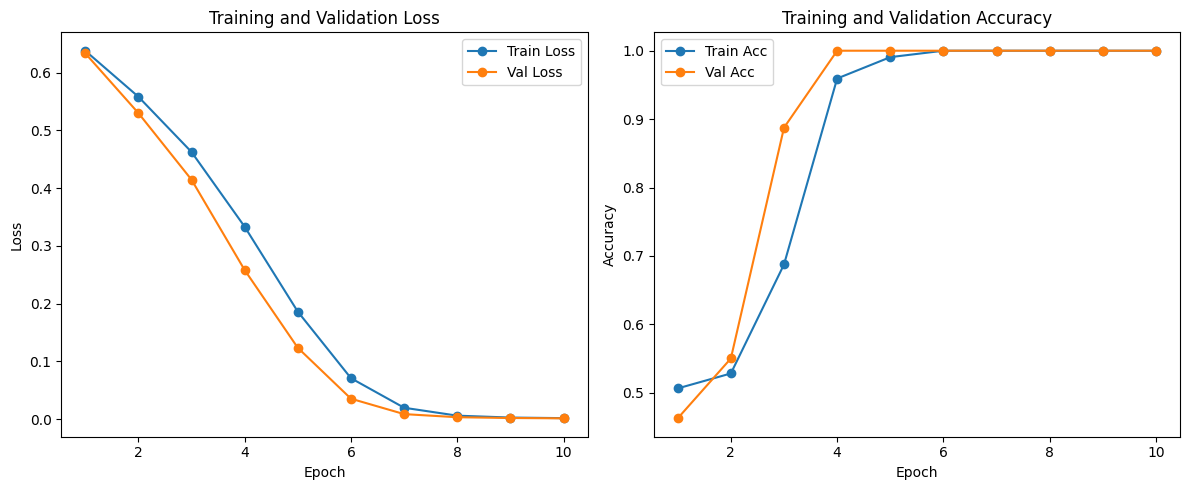

Final Test Loss: 0.0016, Final Test Acc: 1.0000
Confusion Matrix:
[[43  0]
 [ 0 37]]


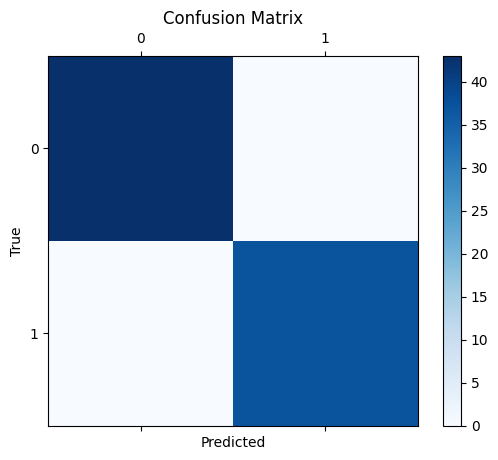

In [34]:
#####################
# Main Entry Point  #
#####################

def main():
    # Use GPU if available, else CPU.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Hyperparameters for the simulation and training.
    lattice_size = 16      # N x N lattice.
    num_samples = 200      # Number of configurations per temperature.
    temperatures = [1.5, 3.0]  # Example: one below Tc, one above Tc.
    Tc = 2.269
    batch_size = 32
    learning_rate = 1e-3
    num_epochs = 10
    n_sweeps = 500         # Number of Metropolis sweeps per configuration.

    # Build the dataset using the Metropolis approach.
    dataset = Ising2DData(
        lattice_size=lattice_size,
        num_samples=num_samples,
        temperatures=temperatures,
        Tc=Tc,
        seed=42,
        n_sweeps=n_sweeps
    )

    # Split dataset into train/test sets (80/20 split).
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # Create DataLoaders for batch processing.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the CNN and send to device.
    model = SimpleCNN(lattice_size=lattice_size).to(device)
    # Use CrossEntropyLoss for binary classification.
    criterion = nn.CrossEntropyLoss()
    # Adam optimizer for training.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to track metrics over epochs.
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Training loop.
    for epoch in range(num_epochs):
        # Train for one epoch.
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        # Validate on the held-out test set each epoch.
        val_loss, val_acc = validate_model(model, test_loader, criterion, device)
        # Record metrics.
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]" +
              f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}," +
              f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Plot the training/validation curves.
    plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

    # Final evaluation on the test set.
    test_loss, test_acc = validate_model(model, test_loader, criterion, device)
    print(f"Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_acc:.4f}")

    # Show confusion matrix.
    evaluate_and_plot_confusion(model, test_loader, device)


if __name__ == "__main__":
    main()

Key Changes:
Metropolis Implementation:

A metropolis_ising function that:
Initializes spins randomly.
Performs a chosen number of Metropolis sweeps over the lattice (updating spins site by site).
Returns the final thermalized configuration.
For each temperature, we run Monte Carlo and store the resulting configuration.
Ising2DData:

Calls metropolis_ising for each sample.
Labels configurations as “ordered” (0) if T<Tc
or “disordered” (1) if T>Tc.

Model and Training:

Same CNN and training loop as before, but now the dataset has physically realistic configurations rather than purely random ones.

## Visualize the data

In [36]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def inspect_dataset(dataset, max_samples=5):
    """
    Display random samples from an Ising2DData dataset in a pandas DataFrame,
    and visualize them using Matplotlib.

    :param dataset: An instance of Ising2DData (already created).
    :param max_samples: Number of random samples to display and plot.
    """
    # Randomly pick unique indices to display.
    indices = random.sample(range(len(dataset)), k=min(max_samples, len(dataset)))

    # Build a list of records for the DataFrame.
    records = []
    for idx in indices:
        config, label = dataset[idx]
        # Convert the 2D config to a flattened list (or keep it as is if you prefer).
        flattened_spins = config.flatten().astype(int).tolist()

        # Note: Flattening 16x16 means 256 columns—this can be large for a DF.
        # If you'd prefer a summary, you could store a subset or shape info only.
        record = {
            "Index": idx,
            "Label (0=Ordered, 1=Disordered)": label,
            "Flattened Spins": flattened_spins
        }
        records.append(record)

    # Create a DataFrame with these records.
    df = pd.DataFrame(records)

    # Display DataFrame (works nicely in Jupyter/Colab).
    display(df)

    # Now, visualize the selected spin configurations.
    for _, row in df.iterrows():
        # Reconstruct the 2D array from the flattened spins.
        config_2d = np.array(row["Flattened Spins"]).reshape(dataset.lattice_size, dataset.lattice_size)

        # Make a simple plot with a red/blue colormap for -1/+1.
        plt.figure(figsize=(3, 3))
        plt.imshow(config_2d, cmap='bwr', vmin=-1, vmax=1, origin='upper')
        plt.title(f"Index {row['Index']} - Label: {row['Label (0=Ordered, 1=Disordered)']}")
        plt.colorbar(label="Spin Value")
        plt.show()

,Index,"Label (0=Ordered, 1=Disordered)",Flattened Spins
0,807,0,"[-1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1,..."
1,43,0,"[1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -..."
2,1542,1,"[1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, ..."
3,1173,1,"[-1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1..."
4,1449,1,"[-1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, ..."
5,1860,1,"[-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, ..."
6,984,0,"[-1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1,..."
7,855,0,"[-1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, ..."
8,1682,1,"[-1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -..."
9,1375,1,"[-1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1,..."


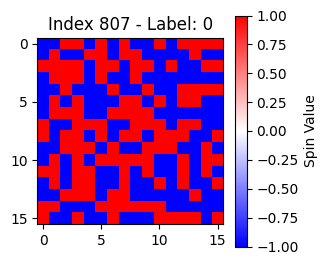

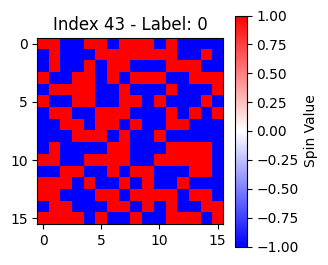

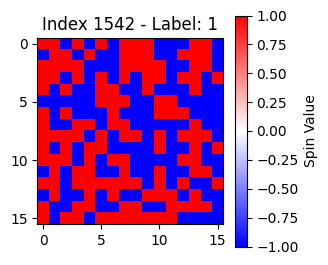

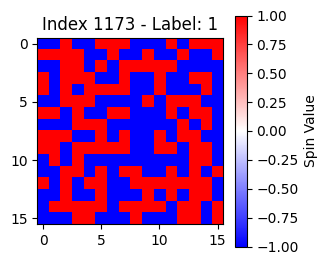

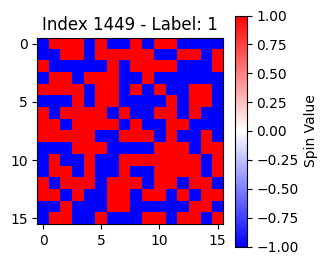

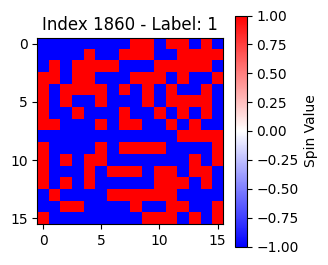

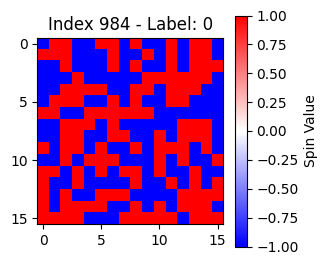

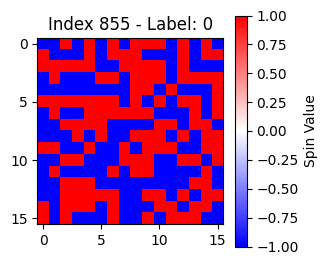

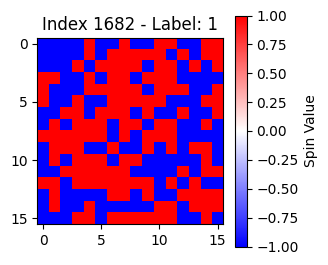

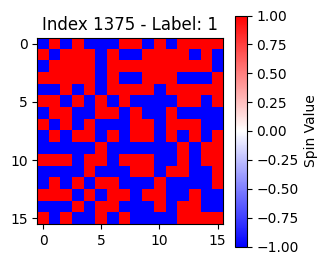

In [40]:
# EXAMPLE USAGE (after dataset is created):
inspect_dataset(dataset, max_samples=10)

In [41]:
import numpy as np

def summarize_dataset(dataset):
    """
    Print basic descriptive info for a 2D Ising dataset.

    - Number of total samples
    - Shape of the spin configurations array
    - Distribution of labels (counts of ordered vs. disordered)
    - Example mean/spin magnetization stats
    """
    # Number of total samples
    print("Total samples in dataset:", len(dataset))

    # Shape of configs (should be [num_samples, lattice_size, lattice_size])
    print("Shape of configs array:", dataset.configs.shape)

    # Label distribution
    unique_labels, counts = np.unique(dataset.labels, return_counts=True)
    print("Label distribution:")
    for lbl, cnt in zip(unique_labels, counts):
        label_name = "Ordered (0)" if lbl == 0 else "Disordered (1)"
        print(f"  {label_name}: {cnt} samples")

    # Example: compute average magnetization for each config
    # Magnetization = average spin value (from -1 to +1)
    magnetizations = [np.mean(cfg) for cfg in dataset.configs]
    overall_mean_mag = np.mean(magnetizations)
    overall_std_mag = np.std(magnetizations)

    print(f"Mean magnetization across the dataset: {overall_mean_mag:.4f}")
    print(f"Std. deviation of magnetization: {overall_std_mag:.4f}")

In [43]:
# EXAMPLE USAGE (after dataset is created):
summarize_dataset(dataset)

Total samples in dataset: 2000
Shape of configs array: (2000, 16, 16)
Label distribution:
  Ordered (0): 1000 samples
  Disordered (1): 1000 samples
Mean magnetization across the dataset: 0.0002
Std. deviation of magnetization: 0.0626


## Randomly generated simulation

Using device: cpu
Epoch [1/10]: Train Loss: 0.6952, Train Acc: 0.4913, Val Loss: 0.6948, Val Acc: 0.4725
Epoch [2/10]: Train Loss: 0.6931, Train Acc: 0.5119, Val Loss: 0.6968, Val Acc: 0.4725
Epoch [3/10]: Train Loss: 0.6911, Train Acc: 0.5288, Val Loss: 0.6928, Val Acc: 0.5150
Epoch [4/10]: Train Loss: 0.6888, Train Acc: 0.5350, Val Loss: 0.6948, Val Acc: 0.5275
Epoch [5/10]: Train Loss: 0.6874, Train Acc: 0.5400, Val Loss: 0.6935, Val Acc: 0.5100
Epoch [6/10]: Train Loss: 0.6806, Train Acc: 0.5681, Val Loss: 0.6956, Val Acc: 0.5200
Epoch [7/10]: Train Loss: 0.6702, Train Acc: 0.5900, Val Loss: 0.6993, Val Acc: 0.5175
Epoch [8/10]: Train Loss: 0.6627, Train Acc: 0.6050, Val Loss: 0.7118, Val Acc: 0.5025
Epoch [9/10]: Train Loss: 0.6438, Train Acc: 0.6288, Val Loss: 0.7078, Val Acc: 0.5300
Epoch [10/10]: Train Loss: 0.6227, Train Acc: 0.6500, Val Loss: 0.7115, Val Acc: 0.5275


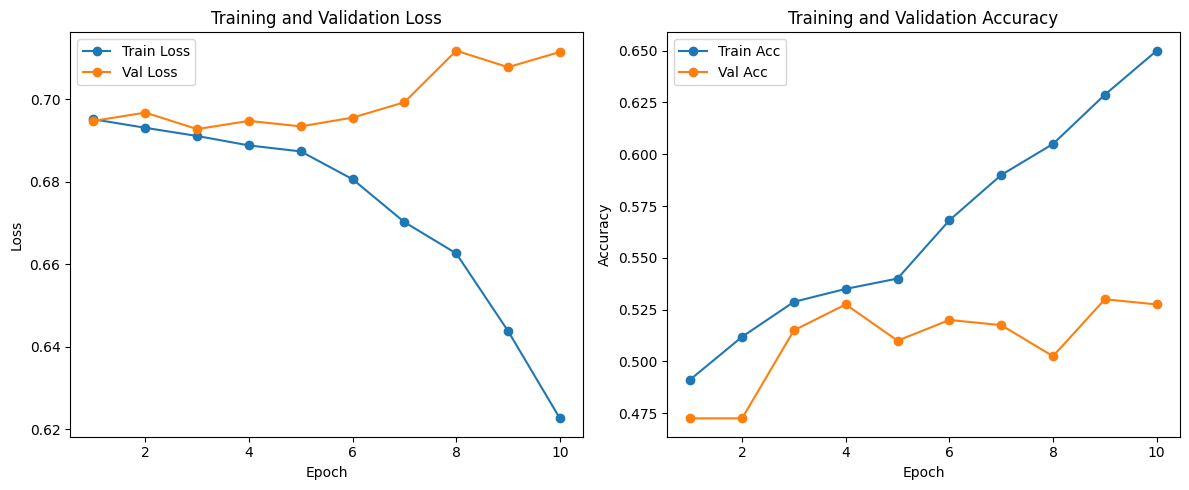

Final Test Loss: 0.7115, Final Test Acc: 0.5275
Confusion Matrix:
[[111 100]
 [ 89 100]]


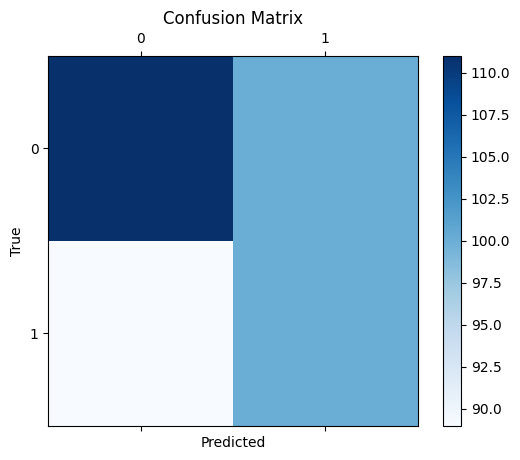

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

"""
This script demonstrates how to use a simple Convolutional Neural Network (CNN)
to classify phases in the 2D Ising model using synthetic spin configurations.

Added visualization code:
1. Track and plot training/validation losses and accuracies.
2. Plot a confusion matrix on the final test set.
"""


class Ising2DData(Dataset):
    """
    Custom PyTorch Dataset for handling 2D Ising spin configurations.
    """
    def __init__(self, lattice_size=16, num_samples=1000, temperatures=[1.0, 3.5], Tc=2.269, seed=42):
        """
        :param lattice_size: Size of the 2D lattice (e.g., 16 for a 16x16 grid).
        :param num_samples: Number of samples to generate for each temperature.
        :param temperatures: Temperatures at which to generate data (list of floats).
        :param Tc: Approximate critical temperature of the 2D Ising model.
        :param seed: Random seed for reproducibility.
        """
        super().__init__()
        np.random.seed(seed)  # Set the random seed for reproducibility.
        self.lattice_size = lattice_size
        self.num_samples = num_samples
        self.temperatures = temperatures
        self.Tc = Tc
        self.configs = []  # Will store the spin configurations.
        self.labels = []   # Will store the labels (0 or 1) for each configuration.
        self.generate_data()  # Generate the synthetic spin configurations.

    def generate_data(self):
        """
        Generates synthetic spin configurations for each temperature in self.temperatures.
        Each spin is randomly assigned +1 or -1.
        The label is 0 (ordered) if T < Tc, else 1 (disordered) if T > Tc.
        """
        for T in self.temperatures:
            for _ in range(self.num_samples):
                # Randomly assign spins to each site on the lattice.
                config = np.random.choice([-1, 1], size=(self.lattice_size, self.lattice_size))

                # Append the configuration to the list.
                self.configs.append(config)

                # Determine label based on temperature.
                label = 0 if T < self.Tc else 1
                self.labels.append(label)

        # Convert configs and labels to numpy arrays for easier handling.
        self.configs = np.array(self.configs, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)

    def __len__(self):
        # Return total number of spin configurations.
        return len(self.configs)

    def __getitem__(self, idx):
        # Retrieve a single spin configuration and its label by index.
        return self.configs[idx], self.labels[idx]


class SimpleCNN(nn.Module):
    """
    A small CNN for binary classification on 2D Ising spin configurations.
    """
    def __init__(self, lattice_size=16):
        super(SimpleCNN, self).__init__()
        # First convolution layer:
        #   in_channels = 1 (we treat spin config as single-channel "image")
        #   out_channels = 8
        #   kernel_size = 3 (3x3 filter)
        #   padding=1 keeps output size same as input in each dimension.
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)

        # Second convolution layer:
        #   in_channels = 8 (from previous layer), out_channels = 16
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)

        # Max-pooling layer:
        #   halves the spatial dimensions (e.g., 16x16 -> 8x8).
        self.pool = nn.MaxPool2d(2, 2)

        # After two pooling operations, the spatial dimension is reduced by a factor of 4.
        # For a lattice_size of 16: 16 -> 8 -> 4 in each spatial dimension.
        # Therefore, the flattened size is 16 (channels) * (16 // 4) * (16 // 4) = 16 * 4 * 4 = 256.
        flatten_size = 16 * (lattice_size // 4) * (lattice_size // 4)

        # First fully connected layer:
        #   input = flatten_size (output from conv layers), output = 32.
        self.fc1 = nn.Linear(flatten_size, 32)

        # Final fully connected layer:
        #   input = 32, output = 2 (binary classification).
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # Pass input through first conv layer, apply ReLU, then pool.
        x = self.pool(F.relu(self.conv1(x)))
        # Pass result through second conv layer, apply ReLU, then pool.
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature maps into a single vector per sample.
        x = x.view(x.size(0), -1)
        # Fully connected layer with ReLU.
        x = F.relu(self.fc1(x))
        # Final layer: outputs raw logits for the two classes.
        x = self.fc2(x)
        return x


def train_model(model, dataloader, criterion, optimizer, device):
    # Set model to training mode.
    model.train()

    running_loss = 0.0  # Accumulate training loss.
    correct = 0         # Track number of correct predictions.
    total = 0           # Track total samples seen.

    for configs, labels in dataloader:
        # Expand spin config dimension to match model (batch, channel, height, width).
        configs = configs.unsqueeze(1).to(device)
        # Move labels to the same device as model parameters.
        labels = labels.to(device)

        # Forward pass.
        outputs = model(configs)
        # Compute loss.
        loss = criterion(outputs, labels)

        # Backprop.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics.
        running_loss += loss.item() * configs.size(0)
        _, predicted = torch.max(outputs.data, 1)  # Choose class with highest logit.
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute average loss and accuracy.
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate_model(model, dataloader, criterion, device):
    # Set model to evaluation mode (turn off dropout, etc.).
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient tracking during evaluation.
    with torch.no_grad():
        for configs, labels in dataloader:
            configs = configs.unsqueeze(1).to(device)
            labels = labels.to(device)

            # Forward pass.
            outputs = model(configs)
            # Compute loss.
            loss = criterion(outputs, labels)

            # Accumulate loss and accuracy.
            running_loss += loss.item() * configs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute average loss and accuracy.
    val_loss = running_loss / total
    val_acc = correct / total
    return val_loss, val_acc


def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    """
    Plot training/validation loss and accuracy curves using matplotlib.
    """
    epochs = range(1, len(train_losses) + 1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Losses
    axs[0].plot(epochs, train_losses, label='Train Loss', marker='o')
    axs[0].plot(epochs, val_losses, label='Val Loss', marker='o')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].legend()

    # Plot Accuracies
    axs[1].plot(epochs, train_accs, label='Train Acc', marker='o')
    axs[1].plot(epochs, val_accs, label='Val Acc', marker='o')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


def evaluate_and_plot_confusion(model, dataloader, device):
    """
    Evaluate the model on a dataloader and plot a confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for configs, labels in dataloader:
            configs = configs.unsqueeze(1).to(device)
            labels = labels.to(device)
            outputs = model(configs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate all batches.
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Create confusion matrix.
    # If you want a fancy plot, you can use sklearn, but here we can do a simple 2x2.
    # 0 -> ordered, 1 -> disordered
    # Rows: true label, Columns: predicted label.

    # We'll do it manually, or we can do:
    # from sklearn.metrics import confusion_matrix
    # cm = confusion_matrix(all_labels, all_preds)

    num_classes = 2
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(all_labels, all_preds):
        cm[t, p] += 1

    print("Confusion Matrix:")
    print(cm)

    # Optional: plot the confusion matrix.
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    plt.show()


def main():
    # Select device: CUDA if available, else CPU.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Basic hyperparameters (can be adjusted).
    lattice_size = 16      # NxN spin lattice.
    num_samples = 1000     # Number of configurations per temperature.
    temperatures = [1.0, 3.5]  # Temperatures below and above critical.
    Tc = 2.269
    batch_size = 32        # Batch size for training.
    learning_rate = 1e-3   # Learning rate for Adam optimizer.
    num_epochs = 10        # Number of training epochs.

    # Prepare the dataset.
    dataset = Ising2DData(
        lattice_size=lattice_size,
        num_samples=num_samples,
        temperatures=temperatures,
        Tc=Tc,
        seed=42
    )

    # Split into training and testing sets (80/20 split here).
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # Create data loaders.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the CNN and move it to the selected device.
    model = SimpleCNN(lattice_size=lattice_size).to(device)

    # Define the loss function (CrossEntropyLoss for classification).
    criterion = nn.CrossEntropyLoss()

    # Define the optimizer (Adam in this case).
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists for tracking metrics.
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Training loop.
    for epoch in range(num_epochs):
        # Train for one epoch.
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        # Validate on the test set to monitor generalization.
        val_loss, val_acc = validate_model(model, test_loader, criterion, device)

        # Store metrics.
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Plot learning curves.
    plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

    # Final evaluation on the test set.
    test_loss, test_acc = validate_model(model, test_loader, criterion, device)
    print(f"Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_acc:.4f}")

    # Evaluate and plot confusion matrix on the test set.
    evaluate_and_plot_confusion(model, test_loader, device)


if __name__ == "__main__":
    main()


## Comments

This is How we can visualize the data:

In [23]:
# Suppose you already instantiated the dataset:
dataset = Ising2DData(
    lattice_size=16,
    num_samples=1000,
    temperatures=[1.0, 3.5],
    Tc=2.269,
    seed=42
)

In [24]:
# Check the overall shape of configs and labels
print("Configs shape:", dataset.configs.shape)  # e.g., (2000, 16, 16)
print("Labels shape:", dataset.labels.shape)    # e.g., (2000,)

# Look at the first sample
print("First config:\n", dataset.configs[1])
print("First label:", dataset.labels[1])


Configs shape: (2000, 16, 16)
Labels shape: (2000,)
First config:
 [[-1.  1.  1. -1. -1.  1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.]
 [-1.  1. -1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1. -1.  1.  1.]
 [-1. -1.  1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1. -1.  1. -1.]
 [-1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.]
 [-1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1.]
 [-1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1. -1.]
 [-1.  1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  1.]
 [-1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1.]
 [-1.  1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1.]
 [ 1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1. 

If you’d like to visualize a few spin configurations (like images), you can use Matplotlib. For instance:

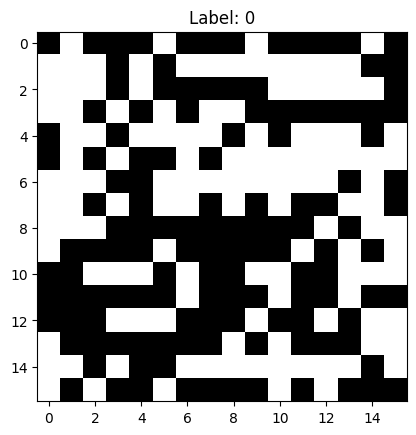

In [25]:
import matplotlib.pyplot as plt

# Plot the first configuration in grayscale
fig, ax = plt.subplots()
# Spin values are +1 or -1, so shift them to 0 or 1 for a simple grayscale plot
ax.imshow((dataset.configs[0] + 1) / 2, cmap='gray')
ax.set_title(f"Label: {dataset.labels[0]}")
plt.show()